<a href="https://colab.research.google.com/github/akshpesa/FMML/blob/main/FMML_ML4_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

In [72]:
# You don't need to understand these functions


def plotGrid(transform, unit, linestyle=":", fig=None, ax=None):
    lim1 = -100
    lim2 = 100

    def mat2xy(start, end):
        if len(start.shape) == 1:
            start = np.expand_dims(start, 0)
            end = np.expand_dims(end, 0)
        nan = np.ones(len(start)) * np.nan
        x = np.stack((start[:, 0], end[:, 0], nan)).T.reshape(-1)
        y = np.stack((start[:, 1], end[:, 1], nan)).T.reshape(-1)
        return x, y

    def parallellines(axis, addend, lines, unit):
        addend = np.repeat(np.expand_dims(addend, 0), lines * 2, 0)
        unit = np.expand_dims(np.arange(-lines, lines) * unit, 1)
        unit = unit - lines
        addend = addend * unit
        lines = np.expand_dims(axis, 0) + addend
        return np.concatenate((lines, lines * -1))

    if fig is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    transform = transform.astype(float)
    xaxis = transform[0]
    yaxis = transform[1]

    # plot lines parallel to the x axis
    lines1 = parallellines(xaxis * lim1, yaxis, 100, unit)
    lines2 = parallellines(xaxis * lim2, yaxis, 100, unit)
    x, y = mat2xy(lines1, lines2)
    plt.plot(x, y, linestyle + "k", linewidth=0.5)
    # plot x axis
    x, y = mat2xy(xaxis * lim1, xaxis * lim2)
    plt.plot(x, y, linestyle, color="#440077")

    # plot  lines parallel to the y axis
    lines1 = parallellines(yaxis * lim1, xaxis, 100, unit)
    lines2 = parallellines(yaxis * lim2, xaxis, 100, unit)
    x, y = mat2xy(lines1, lines2)
    plt.plot(x, y, linestyle + "k", linewidth=0.5)
    # plot y axis
    x, y = mat2xy(yaxis * lim1, yaxis * lim2)
    plt.plot(x, y, linestyle, color="#aa5500")

    return fig, ax


def plotData(X, y, xlabel="hole", ylabel="bound", fig=None, ax=None):
    if fig is None:
        fig, ax = plt.subplots()
    for ii in range(nclasses):
        plt.scatter(X[y == ii, 0], X[y == ii, 1])
    plt.legend([str(i) for i in range(nclasses)])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    lim2 = X.max()
    lim1 = X.min()
    return fig, ax

In [74]:
from collections import Counter
import numpy as np

def NN1(traindata, trainlabel, query, k):
    """
    This function takes in the training data, training labels, a query point, and the value of k,
    and returns the predicted label for the query point using the k-nearest neighbor algorithm.

    traindata: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    trainlabel: numpy array of shape (n,) where n is the number of samples
    query: numpy array of shape (d,) where d is the number of features
    k: the number of nearest neighbors to consider

    returns: the predicted label for the query point which is the most common label among the k nearest neighbors
    """
    diff = traindata - query  # find the difference between features
    sq = diff ** 2            # square the differences
    dist = sq.sum(axis=1)     # sum of squared differences for each point (Euclidean distance)

    # Get the indices of the k smallest distances
    k_nearest_indices = np.argsort(dist)[:k]

    # Get the labels of the k nearest neighbors
    k_nearest_labels = trainlabel[k_nearest_indices]

    # Find the most common label among the k nearest neighbors
    most_common_label = Counter(k_nearest_labels).most_common(1)[0][0]

    return most_common_label



def NN(traindata, trainlabel, testdata):
    """
    This function takes in the training data, training labels and test data
    and returns the predicted labels for the test data using the nearest neighbour algorithm

    traindata: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    trainlabel: numpy array of shape (n,) where n is the number of samples
    testdata: numpy array of shape (m,d) where m is the number of test samples and d is the number of features

    returns: the predicted labels for the test data which is the label of the training data which is closest to each test point
    """
    predlabel = np.array([NN1(traindata, trainlabel, i,1) for i in testdata])
    return predlabel


def Accuracy(gtlabel, predlabel):
    """
    This function takes in the ground-truth labels and predicted labels
    and returns the accuracy of the classifier.

    gtlabel: numpy array of shape (n,) where n is the number of samples
    predlabel: numpy array of shape (n,) where n is the number of samples

    returns: the accuracy of the classifier which is the number of correct predictions divided by the total number of predictions
    """
    assert len(gtlabel) == len(predlabel), "Length of the ground-truth labels and predicted labels should be the same"
    correct = (gtlabel == predlabel).sum()  # Count the number of correct predictions
    return correct / len(gtlabel)


def cumArray(img):
    img2 = img.copy()
    for ii in range(1, img2.shape[1]):
        # for every row, add up all the rows above it.
        img2[ii, :] = img2[ii, :] + img2[ii - 1, :]
    img2 = img2 > 0
    return img2


def getHolePixels(img):
    """
    This function takes in a binary image and returns the pixels that are holes in the image

    img: numpy array of shape (n,m) where n is the height of the image and m is the width of the image

    returns: a binary image of the same shape as the input image where the holes are filled in
    """
    im1 = cumArray(img)
    # rotate and cumulate it again for differnt direction
    im2 = np.rot90(cumArray(np.rot90(img)), 3)
    im3 = np.rot90(cumArray(np.rot90(img, 2)), 2)
    im4 = np.rot90(cumArray(np.rot90(img, 3)), 1)
    # this will create a binary image with all the holes filled in.
    hull = im1 & im2 & im3 & im4
    # remove the original digit to leave behind the holes
    hole = hull & ~(img > 0)
    return hole


def getHullPixels(img):
    """
    This function takes in a binary image and returns the pixels that are the convex hull of the image

    img: numpy array of shape (n,m) where n is the height of the image and m is the width of the image

    returns: a binary image of the same shape as the input image where the convex hull is filled in
    """
    im1 = cumArray(img)
    # rotate and cumulate it again for differnt direction
    im2 = np.rot90(cumArray(np.rot90(img)), 3)
    im3 = np.rot90(cumArray(np.rot90(img, 2)), 2)
    im4 = np.rot90(cumArray(np.rot90(img, 3)), 1)
    # this will create a binary image with all the holes filled in.
    hull = im1 & im2 & im3 & im4
    return hull


def minus(a, b):
    """
    This function takes in two binary images and returns the difference between the two images
    """
    return a & ~b


def getBoundaryPixels(img):
    """
    This function takes in a binary image and returns the pixels that are the boundary of the image

    img: numpy array of shape (n,m) where n is the height of the image and m is the width of the image

    returns: a binary image of the same shape as the input image where the boundary is filled in
    """
    img = img.copy() > 0  # binarize the image
    rshift = np.roll(img, 1, 1)
    lshift = np.roll(img, -1, 1)
    ushift = np.roll(img, -1, 0)
    dshift = np.roll(img, 1, 0)
    boundary = (
        minus(img, rshift)
        | minus(img, lshift)
        | minus(img, ushift)
        | minus(img, dshift)
    )
    return boundary

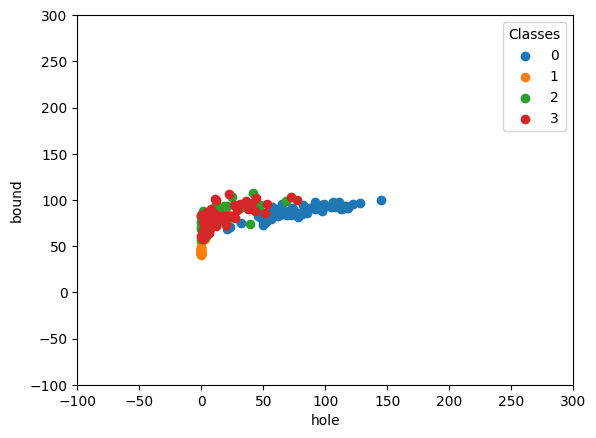

Baseline accuracy: 76.74418604651163 % for 4 classes


In [75]:
import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Load dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X / 255.0
test_X = test_X / 255.0

# Define the class ranges
a1, b1 = 0, 2  # First set of classes
a2, b2 = 2, 4  # Second set of classes

# Helper function to extract data for a given class range
def get_data_for_classes(X, y, a, b):
    X_subset = X[(y >= a) & (y < b)]
    y_subset = y[(y >= a) & (y < b)]
    return X_subset, y_subset

# Extract data for the first set of classes
train_X1, train_y1 = get_data_for_classes(train_X, train_y, a1, b1)
test_X1, test_y1 = get_data_for_classes(test_X, test_y, a1, b1)

# Extract data for the second set of classes
train_X2, train_y2 = get_data_for_classes(train_X, train_y, a2, b2)
test_X2, test_y2 = get_data_for_classes(test_X, test_y, a2, b2)

# Optionally subset the data
train_X1 = train_X1[::100].copy()
train_y1 = train_y1[::100].copy()
test_X1 = test_X1[::100].copy()
test_y1 = test_y1[::100].copy()

train_X2 = train_X2[::100].copy()
train_y2 = train_y2[::100].copy()
test_X2 = test_X2[::100].copy()
test_y2 = test_y2[::100].copy()

# Feature extraction
def extract_features(X):
    hole = np.array([getHolePixels(i).sum() for i in X])
    bound = np.array([getBoundaryPixels(i).sum() for i in X])
    return np.vstack((hole, bound)).transpose()

# Extract features for both class sets
train_feats1 = extract_features(train_X1)
test_feats1 = extract_features(test_X1)
train_feats2 = extract_features(train_X2)
test_feats2 = extract_features(test_X2)

# Combine features
combined_train_feats = np.concatenate((train_feats1, train_feats2), axis=0)
combined_test_feats = np.concatenate((test_feats1, test_feats2), axis=0)

# Combine labels
combined_train_y = np.concatenate((train_y1, train_y2), axis=0)
combined_test_y = np.concatenate((test_y1, test_y2), axis=0)

# Plotting function (adjust as needed)
def plotData(X, y, xlabel='hole', ylabel='bound', fig=None, ax=None):
    if fig is None or ax is None:
        fig, ax = plt.subplots()

    nclasses = len(set(y))
    for ii in range(nclasses):
        indices = y == ii
        if indices.sum() > 0:
            ax.scatter(X[indices, 0], X[indices, 1], label=str(ii))

    ax.legend(title="Classes")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return fig, ax

# Define limits
xlim = [-100, 300]
ylim = [-100, 300]

# Plot the combined features
fig, ax = plotData(combined_train_feats, combined_train_y)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.show()

test_pred = NN(combined_train_feats, combined_train_y, combined_test_feats)
acc = Accuracy(combined_test_y, test_pred)
nclasses = len(set(combined_train_y))
print("Baseline accuracy:", acc * 100, "%", "for", nclasses, "classes")

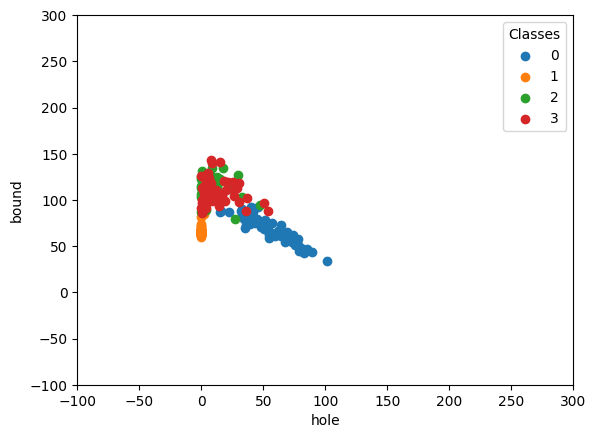

Transformed accuracy: 81.3953488372093 % for 4 classes


In [90]:
transform = np.array([[0.7, -0.8], [0, 1.5]])

train_feats_t = np.matmul(combined_train_feats, transform)
# whatever transform we are applying to the training set should be applied to the test set also
test_feats_t = np.matmul(combined_test_feats, transform)

def plotData(X, y, xlabel='hole', ylabel='bound', fig=None, ax=None):
    if fig is None or ax is None:
        fig, ax = plt.subplots()

    nclasses = len(set(y))
    for ii in range(nclasses):
        indices = y == ii
        if indices.sum() > 0:
            ax.scatter(X[indices, 0], X[indices, 1], label=str(ii))

    ax.legend(title="Classes")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return fig, ax

# Define limits
xlim = [-100, 300]
ylim = [-100, 300]

# Plot the combined features
fig, ax = plotData(train_feats_t, combined_train_y)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.show()

test_pred = NN(train_feats_t, combined_train_y, test_feats_t)
acc = Accuracy(combined_test_y, test_pred)
nclasses = len(set(combined_train_y))
print("Transformed accuracy:", acc * 100, "%", "for", nclasses, "classes")

In [67]:
print("Shape of combined_train_feats:", combined_train_feats.shape)
print("First few rows of combined_train_feats:\n", combined_train_feats[:10])


Shape of combined_train_feats: (248, 2)
First few rows of combined_train_feats:
 [[ 72  87]
 [  0  44]
 [ 47  81]
 [  0  42]
 [ 65  96]
 [ 81  85]
 [ 72  84]
 [105  92]
 [  0  44]
 [ 73  91]]
